In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import json 
import csv
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from catboost import CatBoostClassifier

import sys
sys.path.append("..")

from src.tcga_preprocess_utils import prepare_data, choose_common_patients
from src.mofa_utils import transform_df_for_mofa, preprocess_data_for_mofa, train_mofa

In [2]:
RANDOM_STATE = 42

In [3]:
expression_data_breast = prepare_data('data/breast/exp')
expression_data_breast = preprocess_data_for_mofa(expression_data_breast)

methylation_data_breast = prepare_data('data/breast/methy')
methylation_data_breast = preprocess_data_for_mofa(methylation_data_breast)

mirna_data_breast = prepare_data('data/breast/mirna')
mirna_data_breast = preprocess_data_for_mofa(mirna_data_breast)

expression_data_kidney = prepare_data('data/kidney/exp')
expression_data_kidney = preprocess_data_for_mofa(expression_data_kidney)

methylation_data_kidney = prepare_data('data/kidney/methy')
methylation_data_kidney = preprocess_data_for_mofa(methylation_data_kidney)

mirna_data_kidney = prepare_data('data/kidney/mirna')
mirna_data_kidney = preprocess_data_for_mofa(mirna_data_kidney)

expression_data_breast, methylation_data_breast, mirna_data_breast = choose_common_patients(
    [expression_data_breast, methylation_data_breast, mirna_data_breast])

expression_data_kidney, methylation_data_kidney, mirna_data_kidney = choose_common_patients(
    [expression_data_kidney, methylation_data_kidney, mirna_data_kidney])

In [4]:
common_genes = set(expression_data_breast.columns).intersection(expression_data_kidney.columns)
print('Кол-во общих генов: ', len(common_genes))
common_meth = set(methylation_data_breast.columns).intersection(methylation_data_kidney.columns)
print('Кол-во общих метил: ', len(common_meth))
common_mirna = set(mirna_data_breast.columns).intersection(mirna_data_kidney.columns)
print('Кол-во общих мрнк: ', len(common_mirna))


Кол-во общих генов:  1155
Кол-во общих метил:  128
Кол-во общих мрнк:  168


In [5]:
print('Кол-во общих пациентов: ', len(set(expression_data_breast.index).intersection(expression_data_kidney.index)))

Кол-во общих пациентов:  0


In [6]:
expression_data_breast,  expression_data_kidney = expression_data_breast[
    common_genes], expression_data_kidney[common_genes]
methylation_data_breast, methylation_data_kidney = methylation_data_breast[
    common_meth], methylation_data_kidney[common_meth]
mirna_data_breast, mirna_data_kidney = mirna_data_breast[
    common_mirna], mirna_data_kidney[common_mirna]

In [7]:
transformed_expression_data_breast = transform_df_for_mofa(
    expression_data_breast.copy(), 'DNA')
transformed_methylation_breast = transform_df_for_mofa(
    methylation_data_breast.copy(), 'Methylation')
transformed_mirna_data_breast = transform_df_for_mofa(
    mirna_data_breast.copy(), 'RNA')
combined_data_breast = pd.concat([transformed_expression_data_breast,
                                  transformed_methylation_breast, transformed_mirna_data_breast], axis=0)
combined_data_breast['group'] = 'group_0'

transformed_expression_data_kidney = transform_df_for_mofa(
    expression_data_kidney.copy(), 'DNA')
transformed_methylation_kidney  = transform_df_for_mofa(
    methylation_data_kidney.copy(), 'Methylation')
transformed_mirna_data_kidney  = transform_df_for_mofa(
    mirna_data_kidney.copy(), 'RNA')
combined_data_kidney = pd.concat([transformed_expression_data_kidney,
                                  transformed_methylation_kidney, transformed_mirna_data_kidney], axis=0)
combined_data_kidney['group'] = 'group_1'

combined_data = pd.concat([combined_data_breast, combined_data_kidney], axis=0)
scaler = MinMaxScaler()
combined_data['value'] = scaler.fit_transform(combined_data[['value']])

combined_data

,sample,feature,value,view,group
0,tcga.3c.aaau,AKAP6|9472,0.115106,DNA,group_0
1,tcga.3c.aali,AKAP6|9472,0.116965,DNA,group_0
2,tcga.3c.aalj,AKAP6|9472,0.115593,DNA,group_0
3,tcga.3c.aalk,AKAP6|9472,0.115947,DNA,group_0
4,tcga.4h.aaak,AKAP6|9472,0.118333,DNA,group_0
...,...,...,...,...,...
34939,tcga.mm.a563,hsa-mir-3065,0.112080,RNA,group_1
34940,tcga.mm.a564,hsa-mir-3065,0.122717,RNA,group_1
34941,tcga.mm.a84u,hsa-mir-3065,0.138076,RNA,group_1
34942,tcga.mw.a4ec,hsa-mir-3065,0.115280,RNA,group_1


In [8]:
factors, weights, r2 = train_mofa(combined_data.copy(), RANDOM_STATE)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        




Loaded group='group_0' view='DNA' with N=685 samples and D=1155 features...
Loaded group='group_0' view='Methylation' with N=685 samples and D=128 features...
Loaded group='group_0' view='RNA' with N=685 samples and D=168 features...
Loaded group='group_1' view='DNA' with N=208 samples and D=1155 features...
Loaded group='group_1' view='Methylation' with N=208 samples and D=128 features...
Loaded group='group_1' view='RNA' with N=208 samples and D=168 features...



Model options:
- Automatic Relevance Determination prior on the factors: False
- Automatic Relevance Determination prior on the weights: True
- Spike-and-slab prior on the factors: False
- Spike-and-slab prior on the weights: True
Likelihoods:
- View 0 (DNA): gaussian
- View 1 (Methylation): gaussian
- View 2 (RNA): gaussian




######################################
## Training the model with seed 42 ##
######################################


ELBO before training: -9029079.93 

Iteration 1: time=0.12, ELBO=2620061.53, d

### Предсказание типа рака

In [9]:
target_cancer_type = [0] * expression_data_breast.shape[0]
target_kidney = [1] * expression_data_kidney.shape[0]

target_cancer_type.extend(target_kidney)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(factors, target_cancer_type, test_size=0.25, random_state=RANDOM_STATE, stratify=target_cancer_type)

In [11]:
cb_classifier = CatBoostClassifier(n_estimators=5000, random_state=RANDOM_STATE, silent=True)
cb_classifier.fit(X_train, y_train)

y_pred = cb_classifier.predict(X_test)
y_probas = cb_classifier.predict_proba(X_test)

In [12]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_probas[:, 1])

print(f'Accuracy: {accuracy}, F1: {f1}')

Accuracy: 0.9107142857142857, F1: 0.7872340425531914


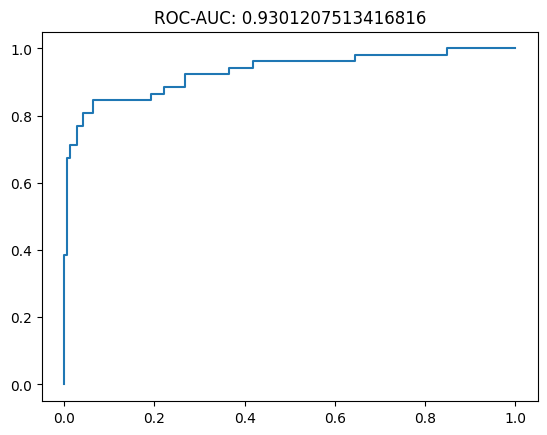

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, y_probas[:, 1])

plt.plot(fpr, tpr)
plt.title(f'ROC-AUC: {roc_auc}');

#### GridSearch по параметрам MOFA и модальнастям

In [14]:
params_grid = {
    'n_factors': range(10, 31, 10),
    'iter': range(1000, 5001, 1000),
    'tolerance': [None, 1e-2, 1e-3],
    'convergence_mode': ['slow', 'medium', 'fast']
}

In [15]:
best_model = None
best_score = float('-inf')
best_params = None
results = []

for params in ParameterGrid(params_grid):
    train_params = {k: v for k, v in params.items() if k != 'n_factors'}

    factors_, weights_, r2_ = train_mofa(combined_data.copy(
    ), factors=params['n_factors'], random_state=RANDOM_STATE, train_params=train_params)

    clear_output()

    X_train_, X_test_, y_train_, y_test_ = train_test_split(factors_, target_cancer_type, test_size=0.25, random_state=RANDOM_STATE, stratify=target_cancer_type)

    score = float('-inf')
    try:
        cb_classifier.fit(X_train_, y_train_)
        y_pred_ = cb_classifier.predict(X_test_)
        y_probas_ = cb_classifier.predict_proba(X_test_)
        roc_auc = roc_auc_score(y_test_, y_probas_[:, 1])
        score = roc_auc

        print(params, score)
        results.append({'params': params, 'score': score})
        
    except Exception as e:
        print(e)

    if score > best_score:
        best_score = score
        best_params = params

grid_search_results = pd.DataFrame(columns=['Params', 'ROC AUC'])
grid_search_results['Params'] = list(map(lambda r: r['params'], results))
grid_search_results['ROC AUC'] = list(map(lambda r: r['score'], results))
grid_search_results.to_csv('grid_search.csv')

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

{'convergence_mode': 'fast', 'iter': 5000, 'n_factors': 30, 'tolerance': 0.001} 0.9542710196779964
Best parameters: {'convergence_mode': 'medium', 'iter': 1000, 'n_factors': 10, 'tolerance': None}
Best score: 0.9661225402504472
